# matplotlib 시각화를 위한 셀

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 여러가지 Library Import

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

#  데이터 불러오기

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.

[Target] 
- price : 타겟 변수인 집의 가격

[Data]
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. **sqft_living** : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. **waterfront** : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. **condition** : 집의 전반적인 상태
12. **grade** : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [8]:
!ls ../input/d/cookierhkwk/2019-2nd-ml-month-with-kakr

test.csv  train.csv


In [9]:
dir_path = '../input/d/cookierhkwk/2019-2nd-ml-month-with-kakr'
train_data_path = join(dir_path, 'train.csv')
test_data_path = join(dir_path, 'test.csv')
# sub_data_path = join(dir_path, 'sample_submission.csv')

- [Trouble] 우측 Data창에는 분명 ../input/2019-2nd-ml-month-with-kakr/test.csv이 파일경로인데, ls로 살펴보면 ../input에 csv파일이 저장되어 있음
  - 왜 ?

In [11]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
# sub = pd.read_csv(sub_data_path)

print(f'train data dim : {train.shape}')
print(f'sub data dim : {test.shape}')
# print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


- 참고자료
  - [del keyword](https://www.w3schools.com/python/ref_keyword_del.asp)
  - [DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)

- 학습 데이터에서 라벨 제거: `price` 컬럼은 따로 `y`라는 변수에 저장한 후 해당 컬럼은 지워줍니다.

In [12]:
y = train['price']
del train['price']

- 학습 데이터와 테스트 데이터 합치기
  - 전체 데이터에 대해 탐색해보기 위해 두 데이터를 `pd.concat`
  - 데이터를 합치기 전 `train_len`에 `training data`의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용

In [13]:
#★
train_len = len(train)
data = pd.concat((train, test), axis=0)

In [14]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 with LIBRARY: missingno
### 결측치
#### 확인
`missingno` 라이브러리의 `matrix` 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

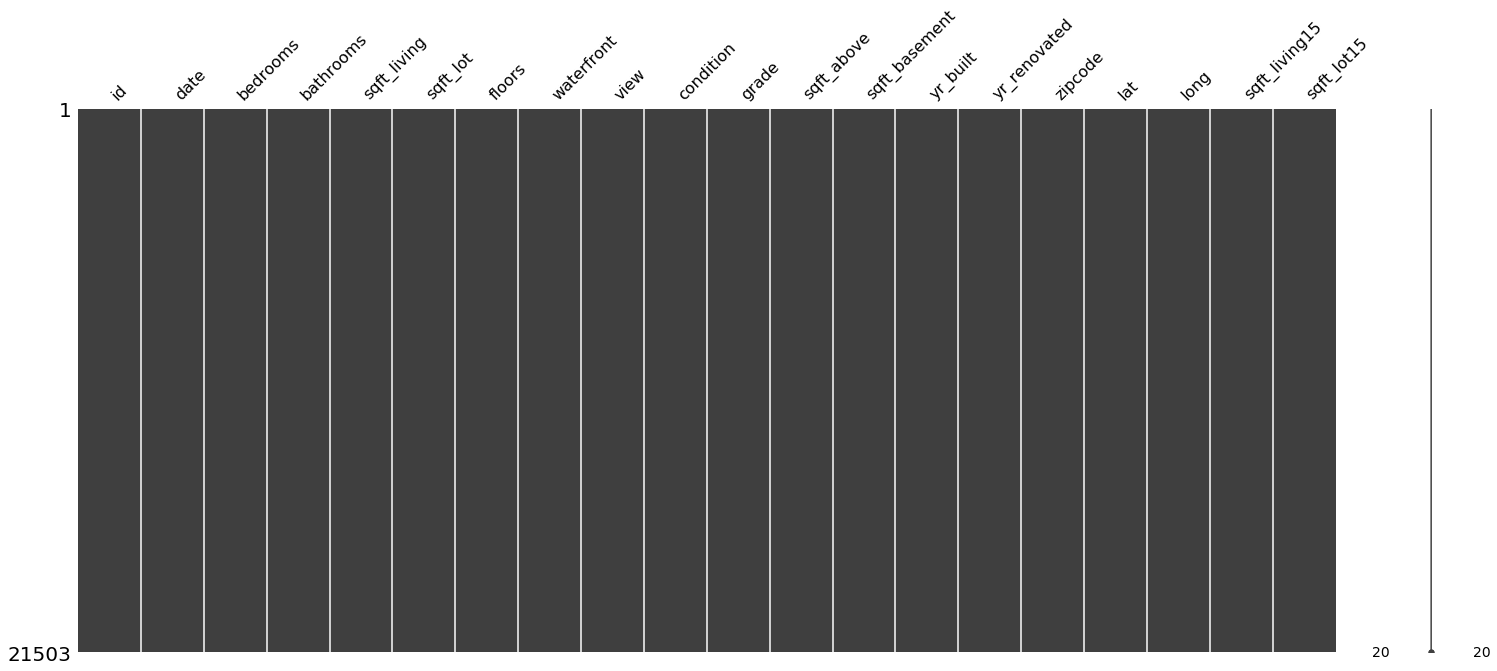

In [15]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [16]:
for c in data.columns:
#     print(f'{c} : { len( data.loc[ data[c].isnull(), c].values ) }')
    print(f'{c} : {data[c].isnull().sum()}')

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

 - 참고자료: [Pandas Lambda, apply를 활용하여 복잡한 로직 적용하기](https://data-newbie.tistory.com/207)

In [17]:
#test data에서는 입력으로 쓰임! 남기기!
test_id = data['id'][train_len:]
del data['id']

In [18]:
len(test_id)

6468

In [19]:
data['date'] = data['date'].map(lambda x : str(x[:6]))
data['date'] = pd.to_datetime(data['date'], format='%Y%m')
data['year'] = data['date'].dt.year # int형
data['month'] = data['date'].dt.month # int형
# data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

In [20]:
print(data.columns)
len(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month'],
      dtype='object')


21

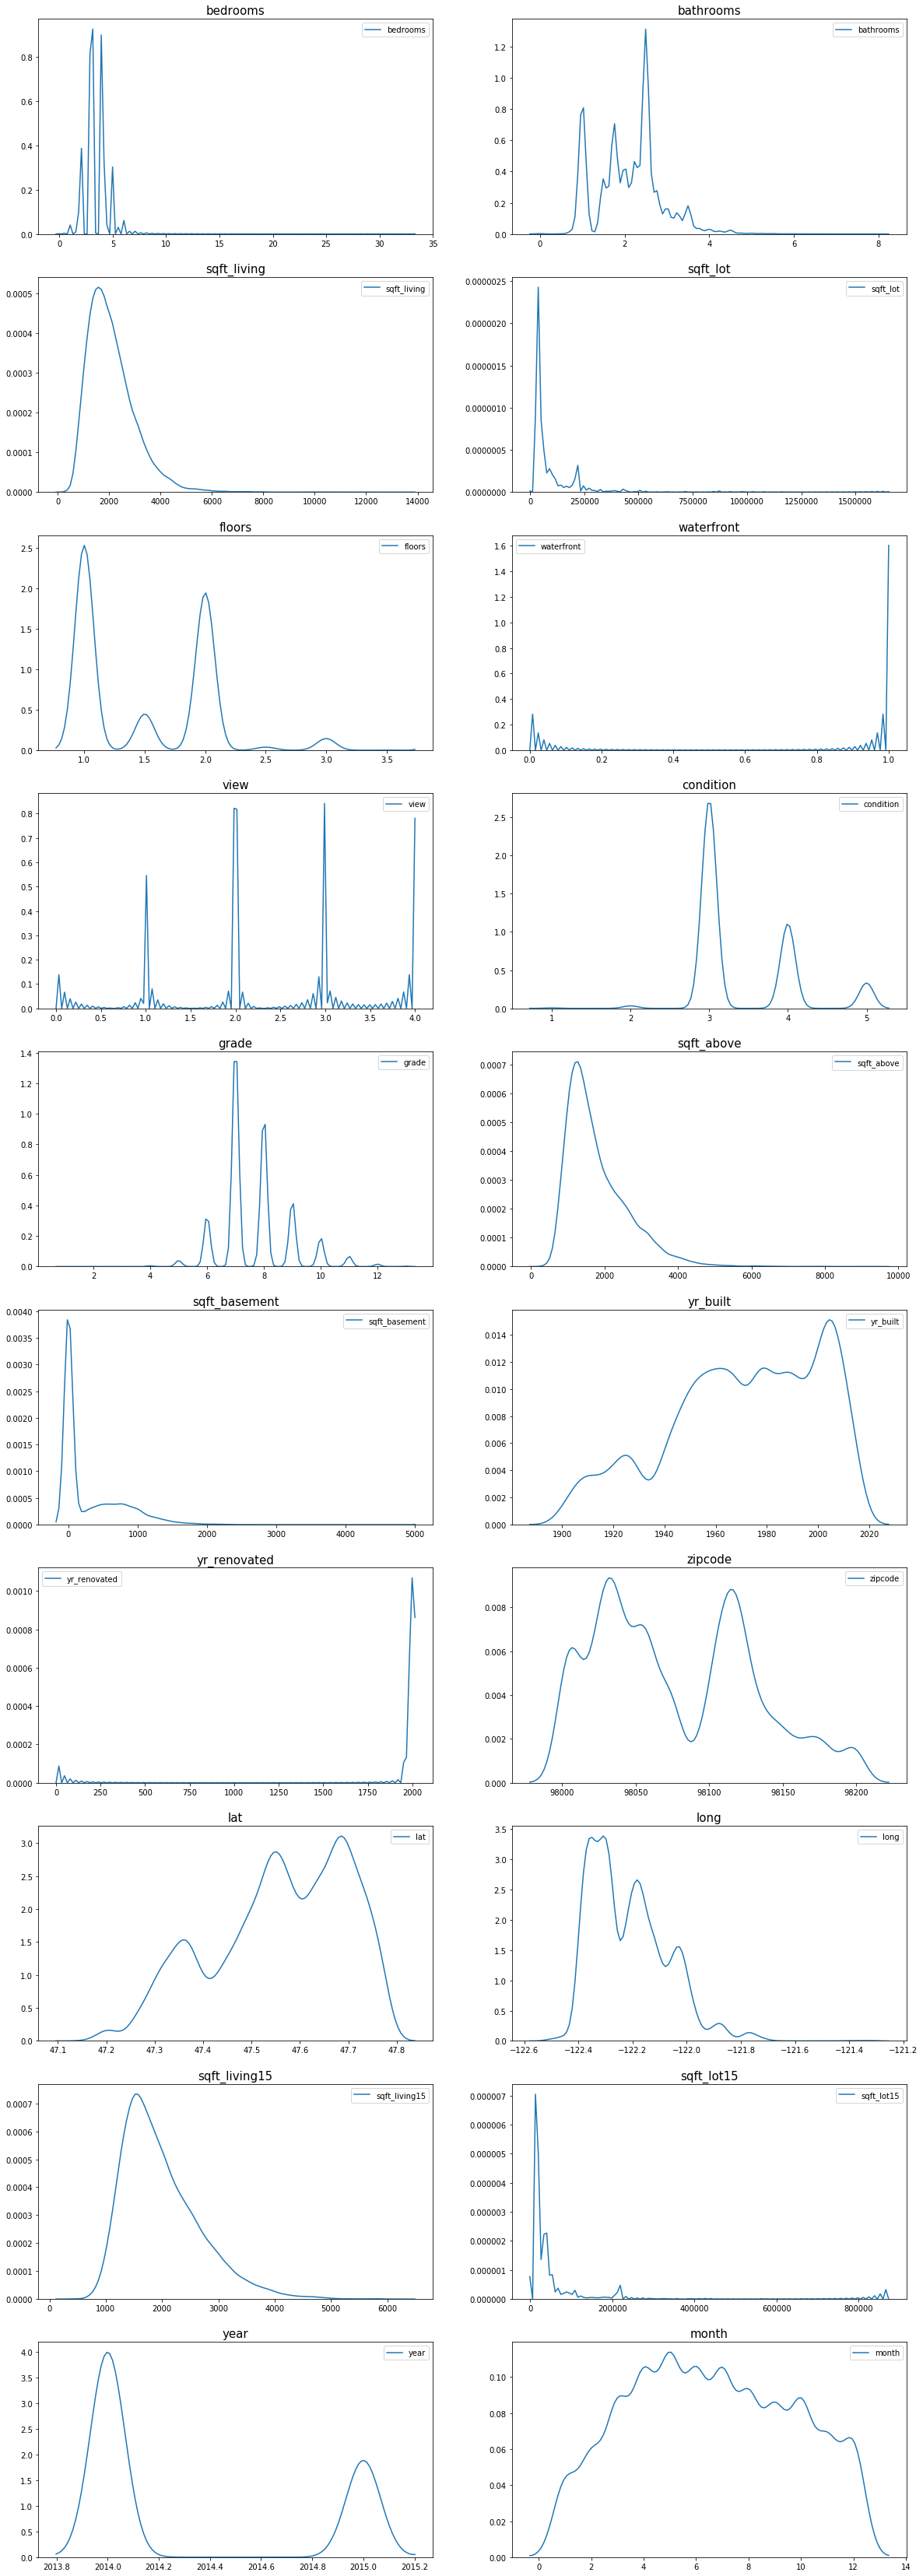

In [21]:
fig, axes = plt.subplots(10, 2, figsize = ( 20, 60))

# id 변수는 제외하고 분포를 확인합니다.

columns = data.columns
for idx, ax in enumerate(axes.flatten(), 1):
    if idx == len(columns) :
        break
    sns.kdeplot(data[columns[idx]], ax = ax)
    ax.set_title(columns[idx], fontsize = 15)
    
# count = 0
# for row in range(11):
#     for col in range(2):
#         sns.kdeplot(data[columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(columns[count], fontsize=15)
#         count+=1
#         if count == 19 :
#             break

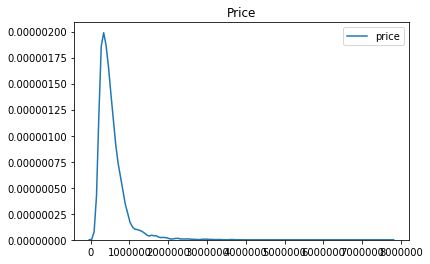

In [22]:
sns.kdeplot(y)
plt.title('Price')
plt.show()

- `price`, `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement` 변수가 한쪽으로 치우친 경향
  - `bedrooms` 은 안치우쳤는데 왜 치우쳤다고 한거지 ?
- log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

- `numpy.log1p()` 함수는 입력 배열의 각 요소에 대해 자연로그 `log(1 + x)`을 반환해 주는 함수
  - 자료의 범위가 >= 0 일 경우에 음수값이 없도록 만들어 주는 로그변환!

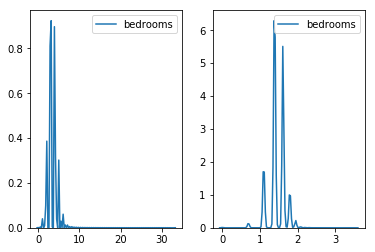

In [23]:
#temp: 딱히 기울어진 것도, 기울어진게 개선되지도 않음
temp = data['bedrooms']
temp_log = np.log1p(data['bedrooms'])

fig, axes = plt.subplots(1,2)
sns.kdeplot(temp, ax = axes[0])
sns.kdeplot(temp_log, ax = axes[1])

In [24]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

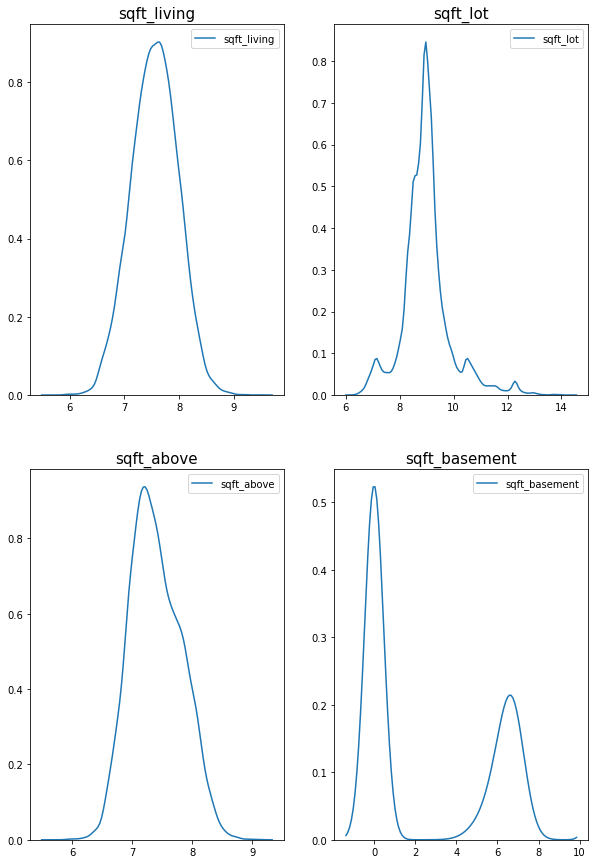

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

for idx, ax in enumerate(axes.flatten()):
    if idx == len(skew_columns):
            break
    sns.kdeplot(data[skew_columns[idx]], ax=ax)
    ax.set_title(skew_columns[idx], fontsize=15)

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

- 왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까?
  - log는 0 ~ 1 사이의 값은 펼쳐주고, 아주 큰 값은 모아준다!
    - 0 ~ 1 사이에 값이 많아서 왼쪽으로 치우친 분포는 치우침이 줄어들게 된다
    - 아주 큰 값에 값이 많아서 skewed to right분포는 꼬리가 줄어들게 된다

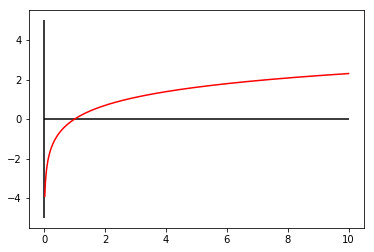

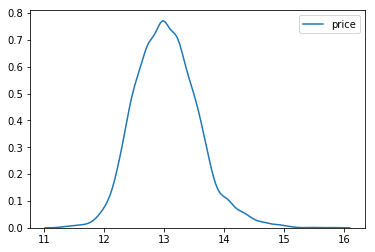

In [26]:
#Test
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

- 결측값 확인, 기울어진 분포를 수정한 데이터를 train과 test 데이터에 저장한다
  - 어떤 특성 공학도 하지 않음!!

In [27]:
x = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

In [28]:
print(x.info())
print(x.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 21 columns):
date             15035 non-null datetime64[ns]
bedrooms         15035 non-null int64
bathrooms        15035 non-null float64
sqft_living      15035 non-null float64
sqft_lot         15035 non-null float64
floors           15035 non-null float64
waterfront       15035 non-null int64
view             15035 non-null int64
condition        15035 non-null int64
grade            15035 non-null int64
sqft_above       15035 non-null float64
sqft_basement    15035 non-null float64
yr_built         15035 non-null int64
yr_renovated     15035 non-null int64
zipcode          15035 non-null int64
lat              15035 non-null float64
long             15035 non-null float64
sqft_living15    15035 non-null int64
sqft_lot15       15035 non-null int64
year             15035 non-null int64
month            15035 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(12)
memory usage: 2.5 M

In [29]:
# data = x['date']
x = x[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month']]
test = test[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month']]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.
- Ensemble, Blending 모델
  - Voting: 다수결 투표, 분류문제
  - Averaging, Bagging: 산술/가중 평균, 회귀문제
- 참고자료
  - [수비니움-Part 1. Introduction to Ensemble Learning](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4)
  - [kaggle ensemble guide[한]](https://gentlej90.tistory.com/73)
    - 왜 여러개의 모델이 더 좋은가 ? X ~ B(n, p = 0.7)를 떠올려보자!
  - [kaggle ensemble guide[영]](https://mlwave.com/kaggle-ensembling-guide/?lipi=urn%3Ali%3Apage%3Ad_flagship3_pulse_read%3BPZ4T3JLHTu%2BOWNI0d5kFbg%3D%3D)

### Boosting 모델의 Blending

In [30]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)
#★사용할 모델과 모델명을 가진 딕셔너리의 리스트!!
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

- def cross_val_score(...)
  - Returns R² when model is Regression
  - 참고자료: [결정계수 R²](https://newsight.tistory.com/259)

In [31]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print(f"Model {m['name']} \
        CV score : {np.mean(cross_val_score(m['model'], x.values, y, cv = kfold)):.4f}")

In [32]:
get_cv_score(models)

Model GradientBoosting         CV score : 0.8618
Model XGBoost         CV score : 0.8613
Model LightGBM         CV score : 0.8808


### Make Submission

In [33]:
def AveragingBlending(models, x, y, test_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([m['model'].predict(test_x.values) for m in models])
    return np.mean(predictions, axis=1)

In [34]:
y_pred = AveragingBlending(models, x, y, test)

In [35]:
test = pd.DataFrame(data={'id':test_id,'price':y_pred})

In [36]:
test.columns

Index(['id', 'price'], dtype='object')

- [Trouble] Kaggle 오류 데이터
  - Kaggle 상에 올라와 있는 data는 test와 submission_sample의 id가 서로 다른 데이터이다. 향후 test와 sample_submission의 sanity check의 필요성을 느낌
    - train id : 0 ~ 15034
    - sample_submission : 15035 ~ 21502
    - test id : 15208 ~ 21762
  - LMS의 데이터를 Kaggle에서 다시 검색해 [옳은 자료](https://www.kaggle.com/cookierhkwk/2019-2nd-ml-month-with-kakr?select=test.csv)를 찾았음

In [88]:
#sub = pd.merge(sub[['id']], test, how = 'left', on = 'id')

In [37]:
test.to_csv('submission.csv', index=False)

# 베이스라인을 설정하였다.
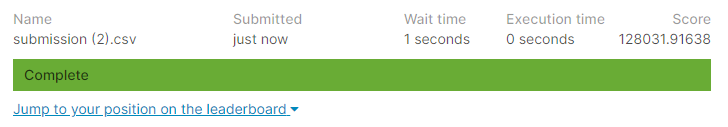